# Neural Network with Tensorflow
In this notebook, i will show you how to build a neural network with Tensorflow to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### 1. Load and prepare data
A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [2]:
data_path = 'data/Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Checking out the data
check out the number of riders for each hour of each day from January 1 2011 to December 31 2012. 

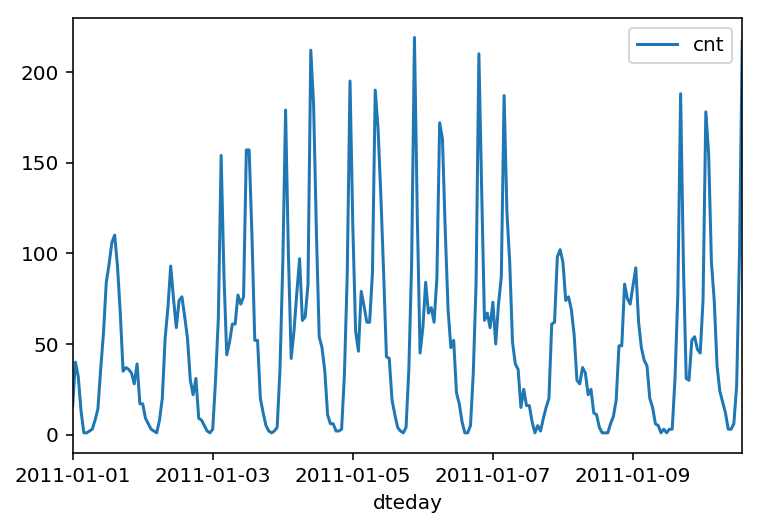

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
There are some categorical variables like season, weather, month in dataset. we need to make them binary dummy variable. [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for field in dummy_fields:
    dummy = pd.get_dummies(rides[field], prefix=field)
    rides = pd.concat([rides, dummy], axis=1)
    
# drop unused data
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Feature scaling
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

Using normalization or min-max scaling? check this [post](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#z-score-standardization-or-min-max-scaling)

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets
We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
#target_fields = ['cnt', 'casual', 'registered']
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### 2. Build Neural Network
In this notebook, i will only use the high-level api **tf.layers** to build network.

**So how many layers and how many units in each hidden layer should be choose?**

"in practice it is often the case that 3-layer neural networks will outperform 2-layer nets, but going even deeper (4,5,6-layer) rarely helps much more. This is in stark contrast to Convolutional Networks, where depth has been found to be an extremely important component for a good recognition system" from Andrej Karpathy
https://cs231n.github.io/neural-networks-1/#arch

In [9]:
def model_inputs(input_size, output_size):
    """
    Create model inputs:
    :param input_size: feature number
    :param output_size: target number
    :return tensor: tuple of (input tensor, output tensor)
    """
    t_input = tf.placeholder(tf.float32, [None, input_size], name="t_input")
    t_target = tf.placeholder(tf.float32, [None, output_size], name="t_output")
    t_prop_drop = tf.placeholder(tf.float32, name="t_prop_drop")
    return t_input, t_target, t_prop_drop


The neural network archtecture would be "input_layer => hidden_layer1(relu) => hidden_layer2(relu) => hidden_layer3(relu) => output_layer"

In [10]:
hidden_layer1_units = 128
hidden_layer2_units = 256

def neural_net(t_input, t_target, lr, prob_dropout):
    """
    Build neural net:
    :param t_input: input data of tensor
    :param t_target: label data of tensor
    :lr: learning rate
    :prob_dropout: dropout rate of tensor
    :return: tuple of (model, loss, pred)
    """
    
    #hidden layer1
    h1 = tf.layers.dense(t_input, hidden_layer1_units, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    h1 = tf.nn.dropout(h1, prob_dropout)
    
    #hidden layer2
    h2 = tf.layers.dense(h1, hidden_layer2_units, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    h2 = tf.nn.dropout(h2, prob_dropout)
    
    #output layer
    logits = tf.layers.dense(h2, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
    tf.identity(logits, "t_pred") # set tensor name for logits operation for later test use.
    
    #loss function
    loss = tf.losses.mean_squared_error(t_target, logits)
    
    
    #optimizer
    model = tf.train.AdamOptimizer(lr, name="model").minimize(loss)
    
    return model, loss, logits

In [11]:
def batch_data(source, target, batch_size):
    """
    Batch source and target together
    """
    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]
        yield np.array(source_batch), np.array(target_batch)

In [12]:
def train(train_features, train_targets, validation_features, validation_targets, prob_dropout, batch_size, epochs,t_input, t_target, t_prop_drop, model, loss, pred, sess):
    losses_list = {'train_loss':[], 'validate_loss':[]}
    sess.run(tf.global_variables_initializer())
    for step in range(epochs):
        #batch the data and training
        batch_num = 0
        for features, targets in batch_data(train_features, train_targets, batch_size):
            batch_num += 1 
            # train model
            sess.run(model, feed_dict={
                t_input: features,
                t_target: targets,
                t_prop_drop: prob_dropout
            })
            
            # every 10 batch, record the loss
            train_loss = sess.run(loss, feed_dict={
                t_input: features,
                t_target: targets,
                t_prop_drop: 1.0
            })
            validate_loss = sess.run(loss, feed_dict={
                t_input: validation_features,
                t_target: validation_targets,
                t_prop_drop: 1.0
            })
            losses_list['train_loss'].append(train_loss)
            losses_list['validate_loss'].append(validate_loss)
        
        #every epoch print the loss
        print("step {0}/{1}: training loss: {2}, validation loss: {3}".format(step, epochs, train_loss, validate_loss))
        
        # Save Model every step
        saver = tf.train.Saver()
        saver.save(sess, save_dir, global_step=step) # save variable vaule every step.
        
    return losses_list
        

In [13]:
#hyper param
epochs = 10
prob_dropout = 0.9
lr = 0.001
batch_size = 128
save_dir = './model/nn3_model'

In [14]:
# build graph
input_size = train_features.shape[1]
output_size = train_targets.shape[1]
t_input, t_target, t_prop_drop = model_inputs(input_size, output_size)
model, loss, pred = neural_net(t_input, t_target, lr, t_prop_drop)

step 0/10: training loss: 0.01589394547045231, validation loss: 0.025443779304623604
step 1/10: training loss: 0.02345443330705166, validation loss: 0.024655835703015327
step 2/10: training loss: 0.018235569819808006, validation loss: 0.017167625948786736
step 3/10: training loss: 0.03236732259392738, validation loss: 0.057708337903022766
step 4/10: training loss: 0.03836575895547867, validation loss: 0.024684302508831024
step 5/10: training loss: 0.007485648617148399, validation loss: 0.0055775088258087635
step 6/10: training loss: 0.003798311110585928, validation loss: 0.0123312221840024
step 7/10: training loss: 0.018370620906352997, validation loss: 0.026707863435149193
step 8/10: training loss: 0.020518101751804352, validation loss: 0.015091604553163052
step 9/10: training loss: 0.006037650164216757, validation loss: 0.00875284243375063
Model Trained and Saved


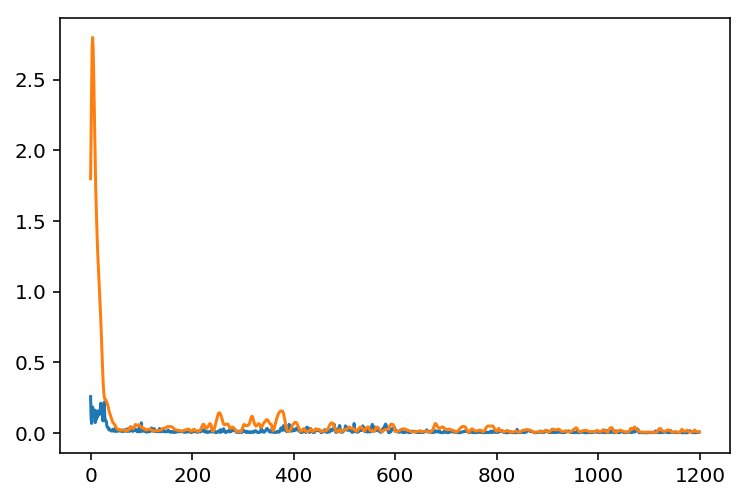

In [15]:
# train model and plot the loss
with tf.Session() as sess:    
    losses_list = train(train_features, train_targets, val_features, val_targets, prob_dropout, batch_size, epochs, t_input, t_target, t_prop_drop, model, loss, pred, sess)
    
# plot train_loss and validate_loss
plt.plot(losses_list['train_loss'])
plt.plot(losses_list['validate_loss'])
print('Model Trained and Saved')
        

### 3. Test and checkout prediction
reconstruct the graph and restroe the variables.

In [16]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess: 
    # import graph and restore the variable
    restore_saver = tf.train.import_meta_graph(save_dir+"-9.meta")
    restore_saver.restore(sess, save_dir+"-9")

    # reconstruct the graph from the meta file
    t_input = loaded_graph.get_tensor_by_name("t_input:0")
    t_target = loaded_graph.get_tensor_by_name("t_output:0")
    t_prop_drop = loaded_graph.get_tensor_by_name("t_prop_drop:0")
    pred = loaded_graph.get_tensor_by_name("t_pred:0")
    
    # make prediction
    pred_values = sess.run(pred, feed_dict = {
        t_input: test_features,
        t_prop_drop: 1.0
    })    

In [17]:
# restore to the un-scailed value
mean, std = scaled_features['cnt']
predictions = pred_values[:,0]*std + mean
original_test_targets = test_targets.values[:,0]*std + mean

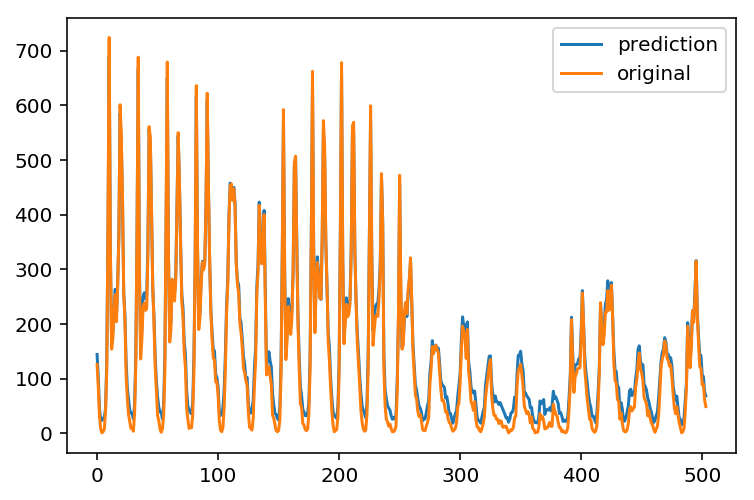

In [18]:
# plot the prediction
plt.plot(predictions, label="prediction")
plt.plot(original_test_targets, label="original")
plt.legend(loc="upper right")
plt.show()

From the plot, we can see, the prediction is not bad.